# Summary

Welcome to the Binary Classification with Bank Churn Dataset competition! In this challenge, our goal is to predict customer churn based on a comprehensive set of information. The dataset comprises 13 columns, each offering valuable insights into customer behavior and characteristics:

    01. Customer ID: A unique identifier for each customer.
    02. Surname: The customer's last name or surname.
    03. Credit Score: A numerical representation of the customer's credit score.
    04. Geography: The country where the customer resides, with options including France, Spain, or Germany.
    05. Gender: The customer's gender, categorized as Male or Female.
    06. Age: The customer's age.
    07. Tenure: The number of years the customer has been associated with the bank.  
    08. Balance: The current account balance of the customer.
    09. NumOfProducts: The count of bank products the customer uses, such as savings accounts or credit cards.
    10. HasCrCard: A binary indicator of whether the customer possesses a credit card (1 = yes, 0 = no).
    11. IsActiveMember: A binary indicator of the customer's active membership status (1 = yes, 0 = no).
    12. EstimatedSalary: The estimated salary of the customer.
    13. Exited: The target variable indicating whether the customer has churned (1 = yes, 0 = no).
    
Throughout the competition, our performance will be evaluated using the Area Under the ROC Curve (AUC-ROC) metric, a widely-used measure for assessing binary classification models. For more details about the original dataset, please refer to the Kaggle dataset page: [Bank Customer Churn Prediction](https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction). Let's embark on this predictive analytics journey and strive for accurate churn predictions!

# Imports

In [1]:
# Libraries for data wrangling
import pandas as pd
import numpy as np 
# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
#Library to see the progress
from tqdm import tqdm


# Libraries with functions used in modelling
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from category_encoders import MEstimateEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.preprocessing import StandardScaler

# Libraries with the models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


# Library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Custom functions to analyze data
from utils.eda_functions import summary_statistics, heatmap, feature_distance
from utils.model_functions import adversarial_validation, cross_val_score


In [3]:
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

In [4]:
seed = 10

# Loading data

In [5]:
df_train = pd.read_csv("data/train.csv", index_col='id')
df_test = pd.read_csv("data/test.csv", index_col='id')

# Descriptive Statistics
Let's begin by taking a peek at our training dataset first

In [6]:
df_train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [7]:
df_train_summary = summary_statistics(df_train)


In [8]:
df_train_summary

,type,count,nunique,%unique,null,%null,min,max
CustomerId,int64,165034,23221,14.070434,0,0.0,15565701,15815690
Surname,object,165034,2797,1.694802,0,0.0,Abazu,Zuyeva
CreditScore,int64,165034,457,0.276913,0,0.0,350,850
Geography,object,165034,3,0.001818,0,0.0,France,Spain
Gender,object,165034,2,0.001212,0,0.0,Female,Male
Age,float64,165034,71,0.043021,0,0.0,18.0,92.0
Tenure,int64,165034,11,0.006665,0,0.0,0,10
Balance,float64,165034,30075,18.223518,0,0.0,0.0,250898.09
NumOfProducts,int64,165034,4,0.002424,0,0.0,1,4
HasCrCard,float64,165034,2,0.001212,0,0.0,0.0,1.0


In [9]:
df_test.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [10]:
df_test_summary = summary_statistics(df_train)
df_test_summary

,type,count,nunique,%unique,null,%null,min,max
CustomerId,int64,165034,23221,14.070434,0,0.0,15565701,15815690
Surname,object,165034,2797,1.694802,0,0.0,Abazu,Zuyeva
CreditScore,int64,165034,457,0.276913,0,0.0,350,850
Geography,object,165034,3,0.001818,0,0.0,France,Spain
Gender,object,165034,2,0.001212,0,0.0,Female,Male
Age,float64,165034,71,0.043021,0,0.0,18.0,92.0
Tenure,int64,165034,11,0.006665,0,0.0,0,10
Balance,float64,165034,30075,18.223518,0,0.0,0.0,250898.09
NumOfProducts,int64,165034,4,0.002424,0,0.0,1,4
HasCrCard,float64,165034,2,0.001212,0,0.0,0.0,1.0


In [11]:
numerical_features = list(df_test._get_numeric_data())
categorical_features = list(df_test.drop(numerical_features, axis = 1))

# Adversarial Validation
The purpose of adversarial validation is to check whether train and test dataset have similar distribution or not. If the validation gives ROC-AUC score of close to .5, we can say that both datasets are similar. However, if it's far from .5, both dataset have different distribution.

The reason we want to do this is to make sure that we can trust our CV score, since a trusted CV only comes from dataset with similar distribution.

Cross-validation: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


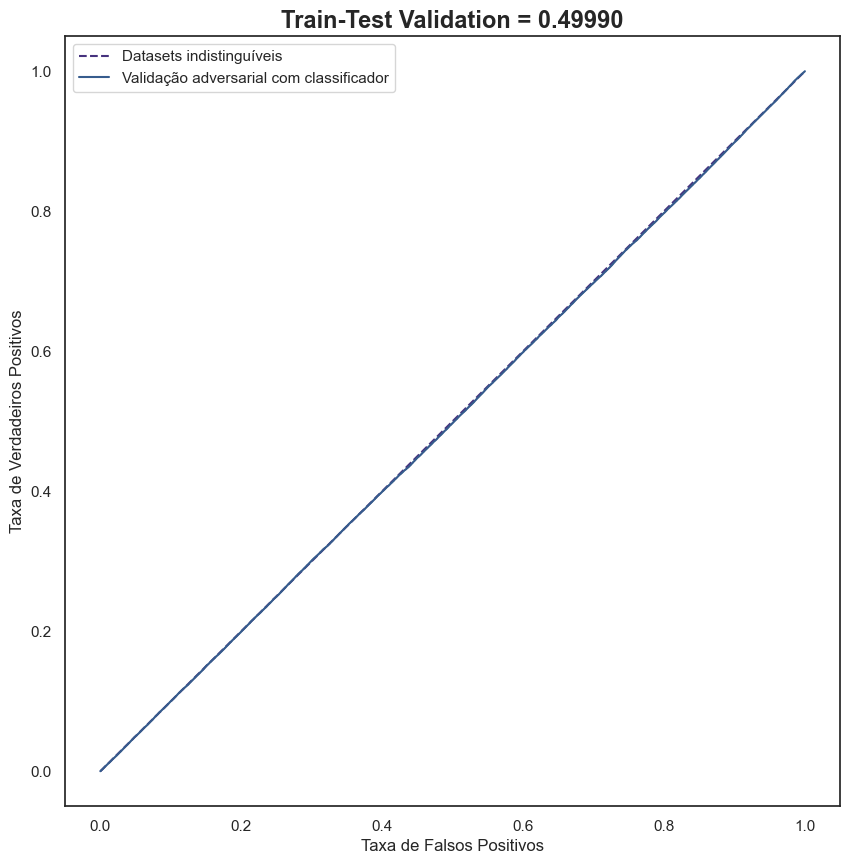

In [12]:
adversarial_validation(df_train, df_test, 'Exited', seed, "Train-Test")

# Distribution of Numerical Features
Now that we have done taking a peek at the descriptive statistics of the datasets and doing adversarial validation, let's try to see the feature distribution this time.

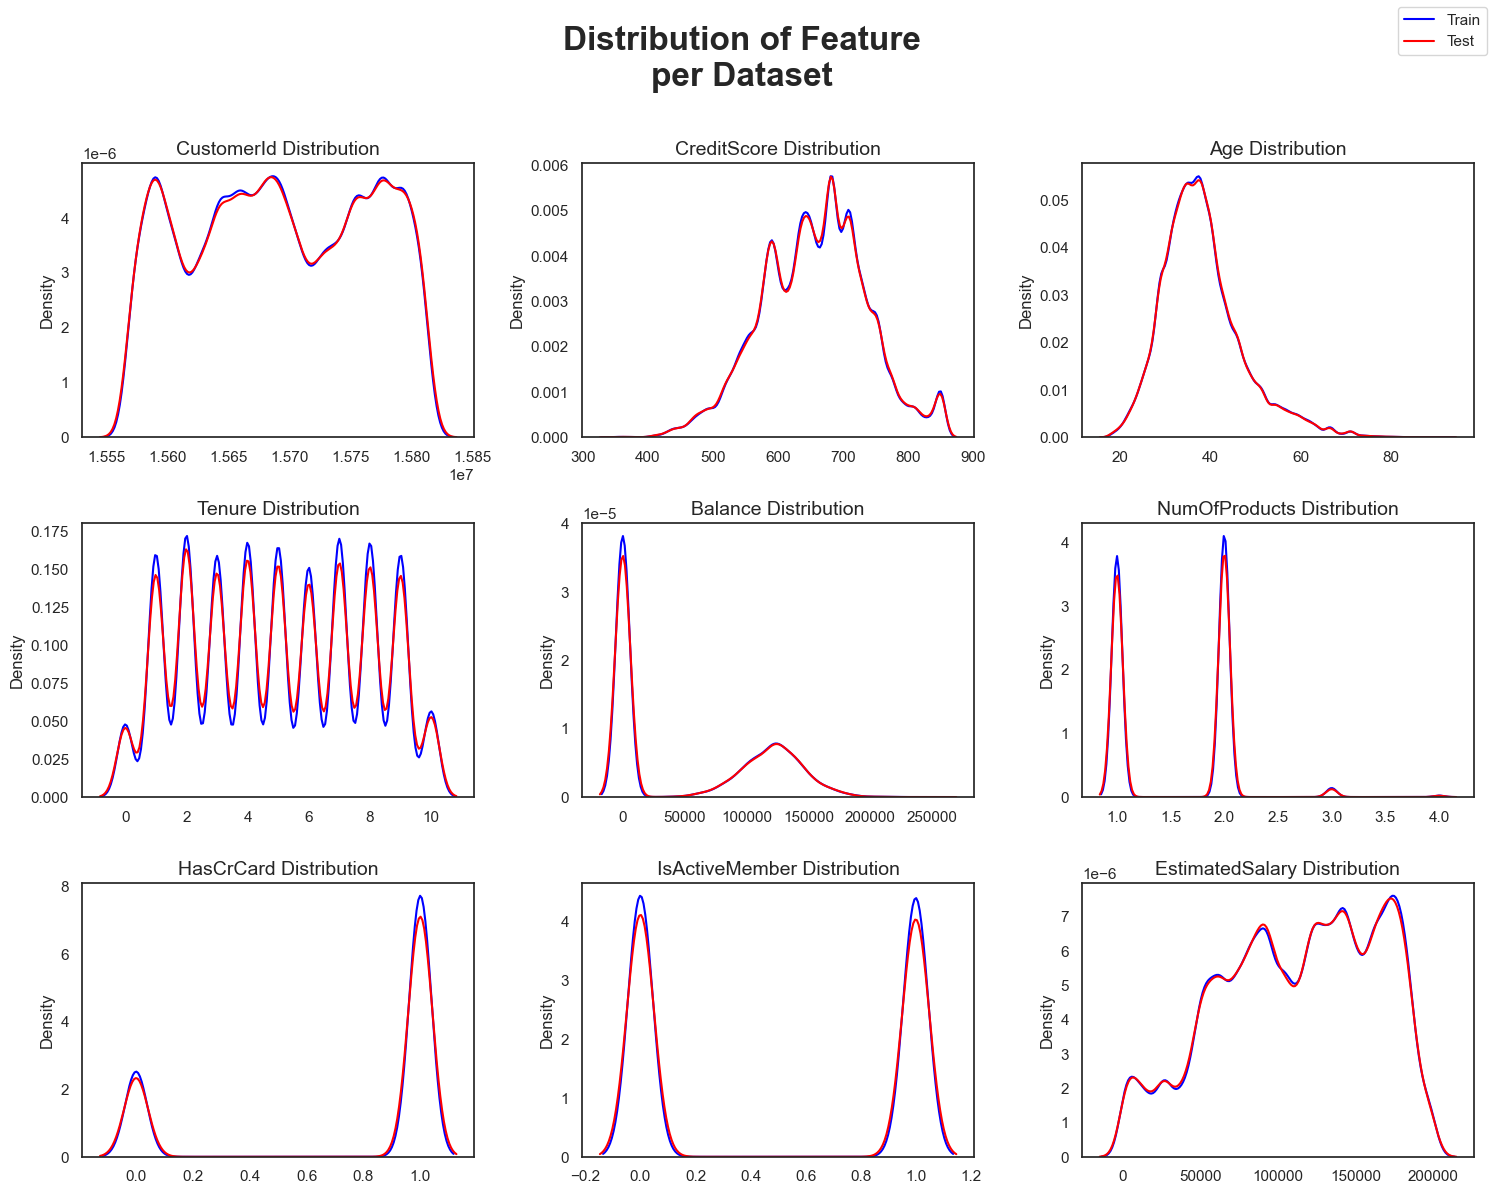

In [13]:
fig, ax = plt.subplots(3, 3, figsize = (15, 12))
ax = ax.flatten()

for i, column in enumerate(numerical_features):
        
    sns.kdeplot(df_train[column], ax=ax[i], color='blue')
    sns.kdeplot(df_test[column], ax=ax[i], color='red', warn_singular = False)

    ax[i].set_title(f'{column} Distribution', size = 14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

The train and test datasets have similar distribution as expected. One thing for sure is that all features are extremely skewed.

# Distribution of Categorical Features

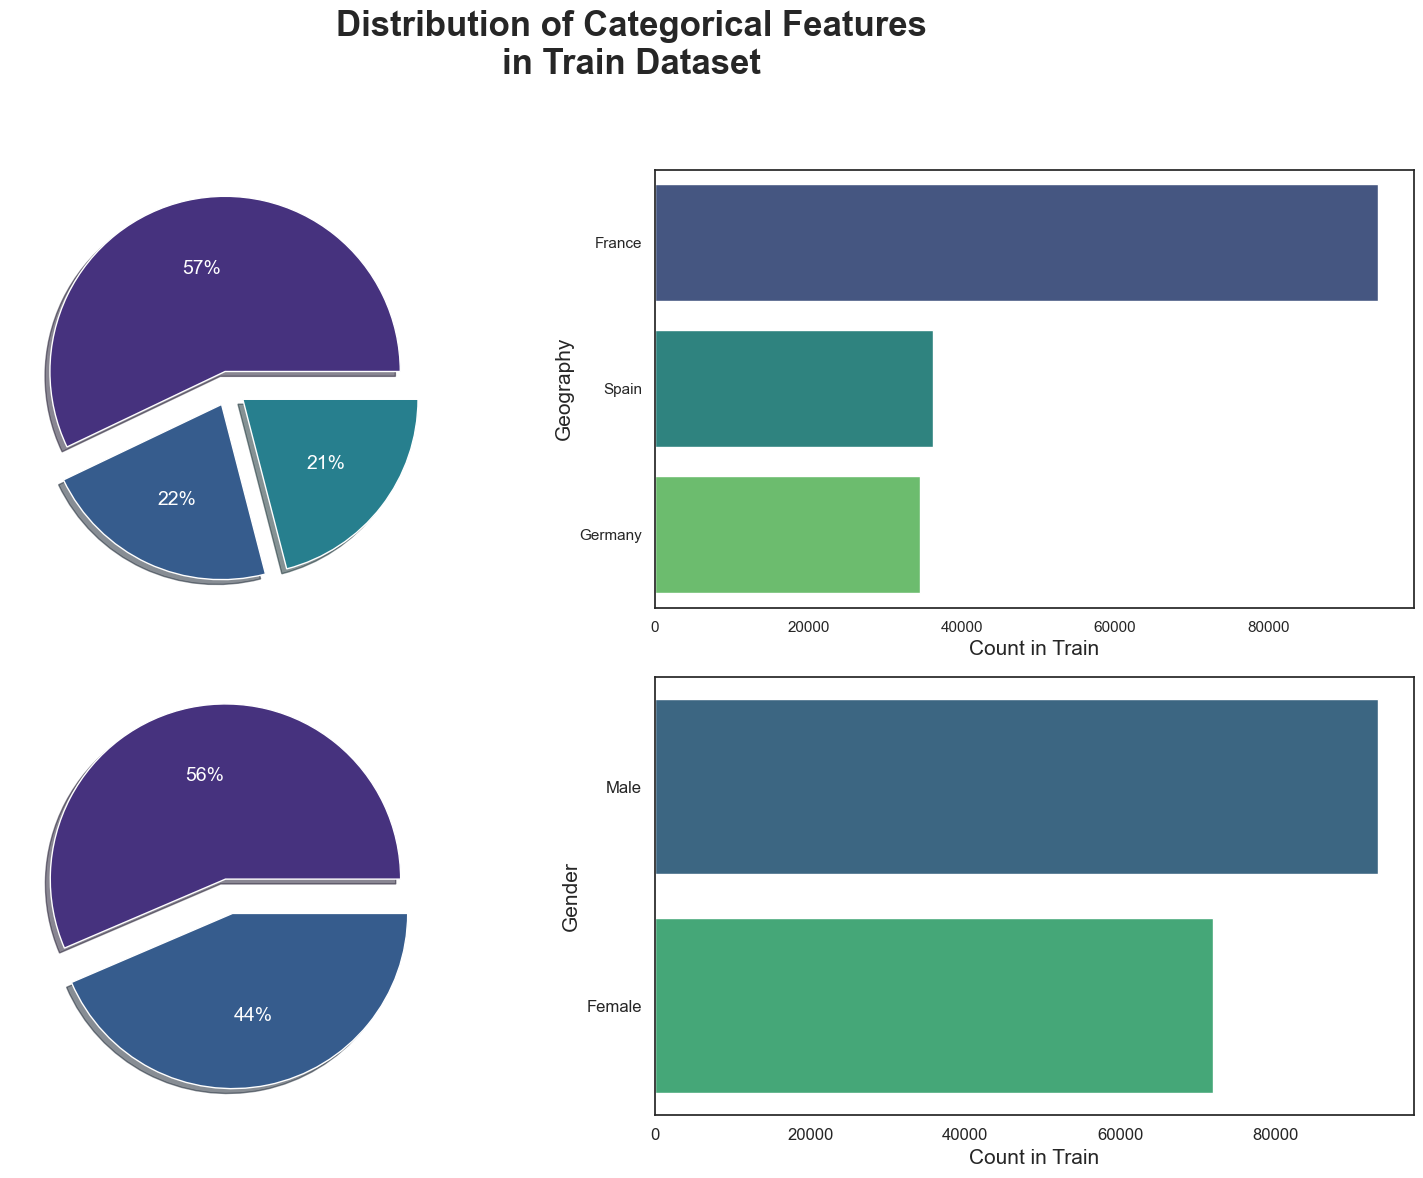

In [14]:
fig, ax = plt.subplots(2, 2, figsize = (16, 12))

for i, column in enumerate(categorical_features[1:]):

    ax[i][0].pie(
        df_train[column].value_counts(), 
        shadow = True, 
        explode = [.1 for i in range(df_train[column].nunique())], 
        autopct = '%1.f%%',
        textprops = {'size' : 14, 'color' : 'white'}
    )

    sns.countplot(data = df_train, y = column, ax = ax[i][1], palette = 'viridis', order = df_train[column].value_counts().index)
    ax[i][1].yaxis.label.set_size(20)
    plt.yticks(fontsize = 12)
    ax[i][1].set_xlabel('Count in Train', fontsize = 15)
    ax[i][1].set_ylabel(f'{column}', fontsize = 15)
    plt.xticks(fontsize = 12)

fig.suptitle('Distribution of Categorical Features\nin Train Dataset\n\n', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

# Target Distribution
We still need to check one last distribution: our target.

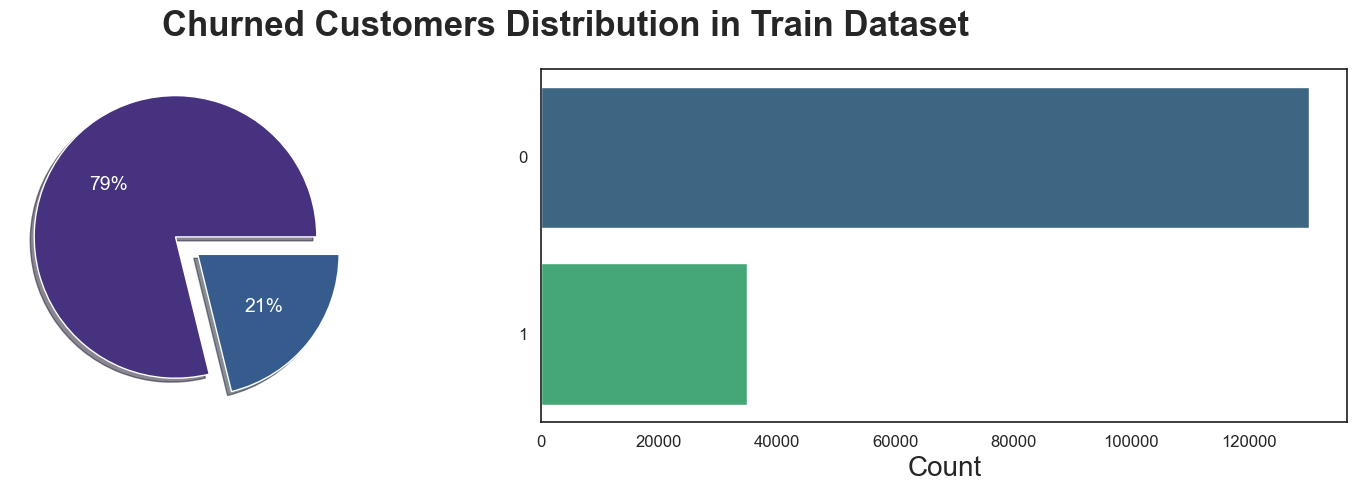

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    df_train['Exited'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(df_train.Exited.nunique())], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = df_train, y = 'Exited', ax = ax[1], palette = 'viridis', order = df_train['Exited'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Churned Customers Distribution in Train Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

# Correlation
If we want to see the relationship between features, we can try calculating the correlation. If two features have negative correlation, it means that an increase of value in one feature will result in a decrease of value in another feature. On the other hand, positive correlation means that an increase of value in one feature will result in an increase of value in another. Let's try to take a look.

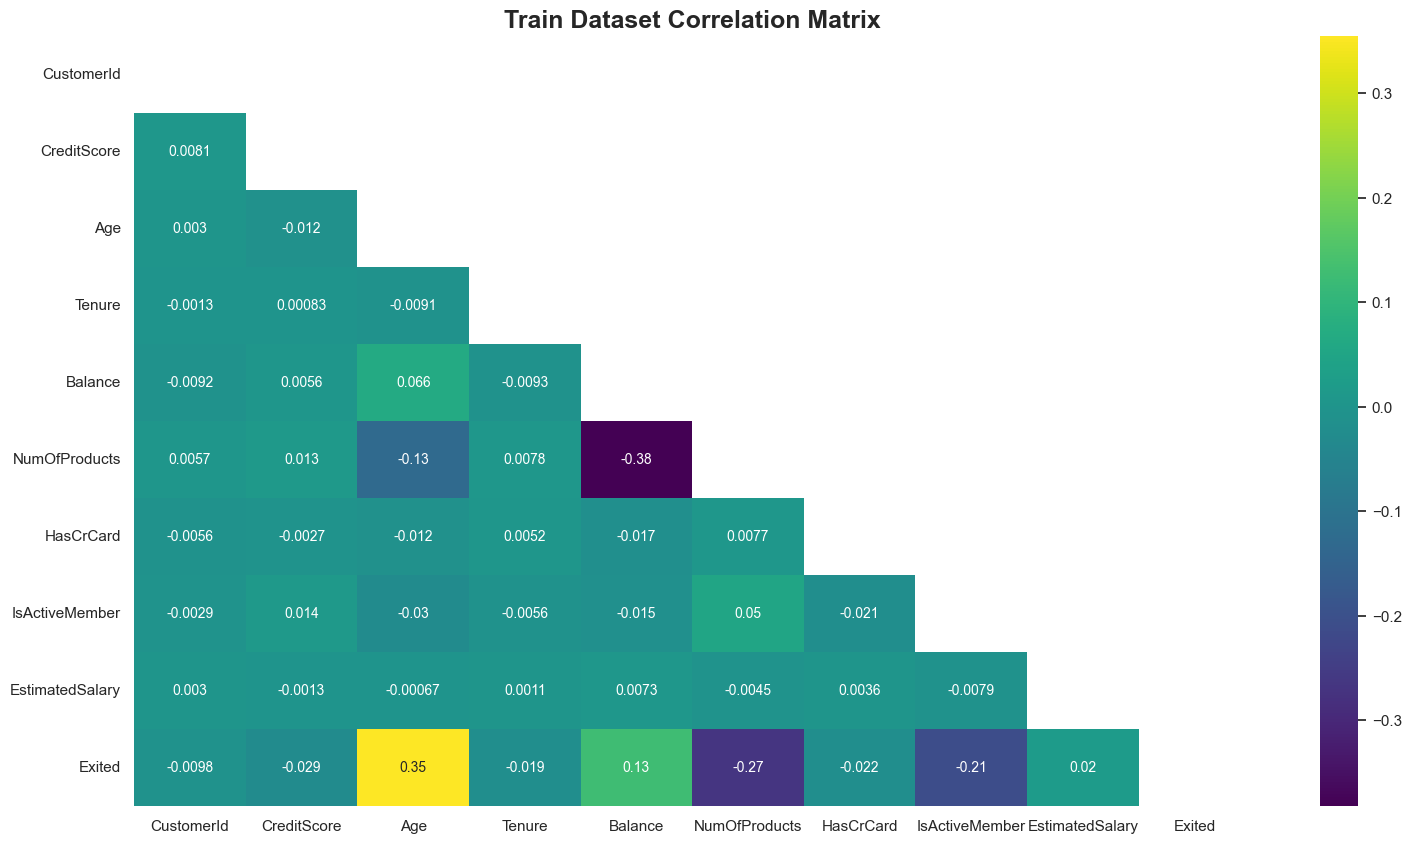

In [16]:
heatmap(dataset=df_train._get_numeric_data(), method='spearman',  label='Train Dataset Correlation Matrix')

We can see from above that there are perfectly correlated features. Let's simplify the matrix with hierarchial clustering.

# Hierarchial Clustering
We can see both the strength and the direction of relaionship between features above. However, if that's too many, we can try to cluster the features with hierarchial clustering.

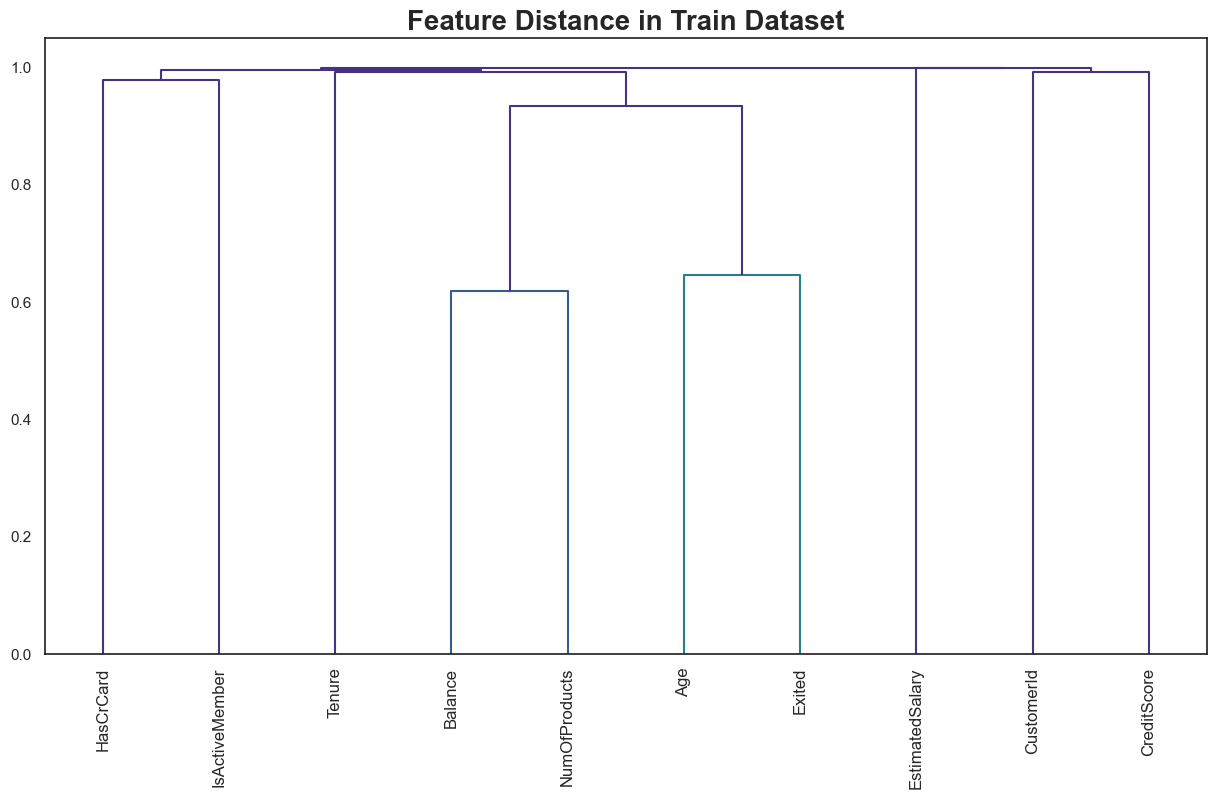

In [17]:
feature_distance(df_train._get_numeric_data(), method='spearman', label='Train')

# Preparation
This is where we start preparing everything if we want to start building machine learning models.

In [18]:
X = df_train.copy()
y = X.pop('Exited')

seed = 10
splits = 5
skf = StratifiedKFold(n_splits = splits, random_state = seed, shuffle = True)
np.random.seed(seed)

# Model Cross Validation
Let's start by evaluating the performance of our model first. We will use M-Estimate Encoder and Standard Scaler in our pipeline. We will also concatenate the original dataset only during the cross-validation process for robustness.

In [24]:
score_list, oof_list = pd.DataFrame(), pd.DataFrame()

models = [
    ('log', LogisticRegression(random_state = seed, max_iter = 1000000)),
    ('lda', LinearDiscriminantAnalysis()),
    ('gnb', GaussianNB()),
    ('bnb', BernoulliNB()),
    ('rf', RandomForestClassifier(random_state = seed)),
    ('et', ExtraTreesClassifier(random_state = seed)),
    ('xgb', XGBClassifier(random_state = seed)),
    ('lgb', LGBMClassifier(random_state = seed)),
    ('dart', LGBMClassifier(random_state = seed, boosting_type = 'dart')),
    ('cb', CatBoostClassifier(random_state = seed, verbose = 0)),
    ('gb', GradientBoostingClassifier(random_state = seed)),
    ('hgb', HistGradientBoostingClassifier(random_state = seed)),
]

for (label, model) in models:
    score_list[label], oof_list[label] = cross_val_score(dataset=df_train, 
                                                         estimator = make_pipeline(MEstimateEncoder(cols = categorical_features), StandardScaler(), model),
                                                         cv = skf,
                                                         seed = seed,
                                                         label=label,
                                                         show_importance = False)

Val Score: 0.82297 ± 0.00178 | Train Score: 0.83654 ± 0.00044 | log
Val Score: 0.82279 ± 0.00175 | Train Score: 0.83677 ± 0.00044 | lda
Val Score: 0.82227 ± 0.00290 | Train Score: 0.83233 ± 0.00070 | gnb
Val Score: 0.82808 ± 0.00168 | Train Score: 0.83402 ± 0.00028 | bnb
Val Score: 0.88196 ± 0.00191 | Train Score: 1.00000 ± 0.00000 | rf
Val Score: 0.88016 ± 0.00176 | Train Score: 1.00000 ± 0.00000 | et
Val Score: 0.88322 ± 0.00154 | Train Score: 0.92722 ± 0.00041 | xgb
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] St

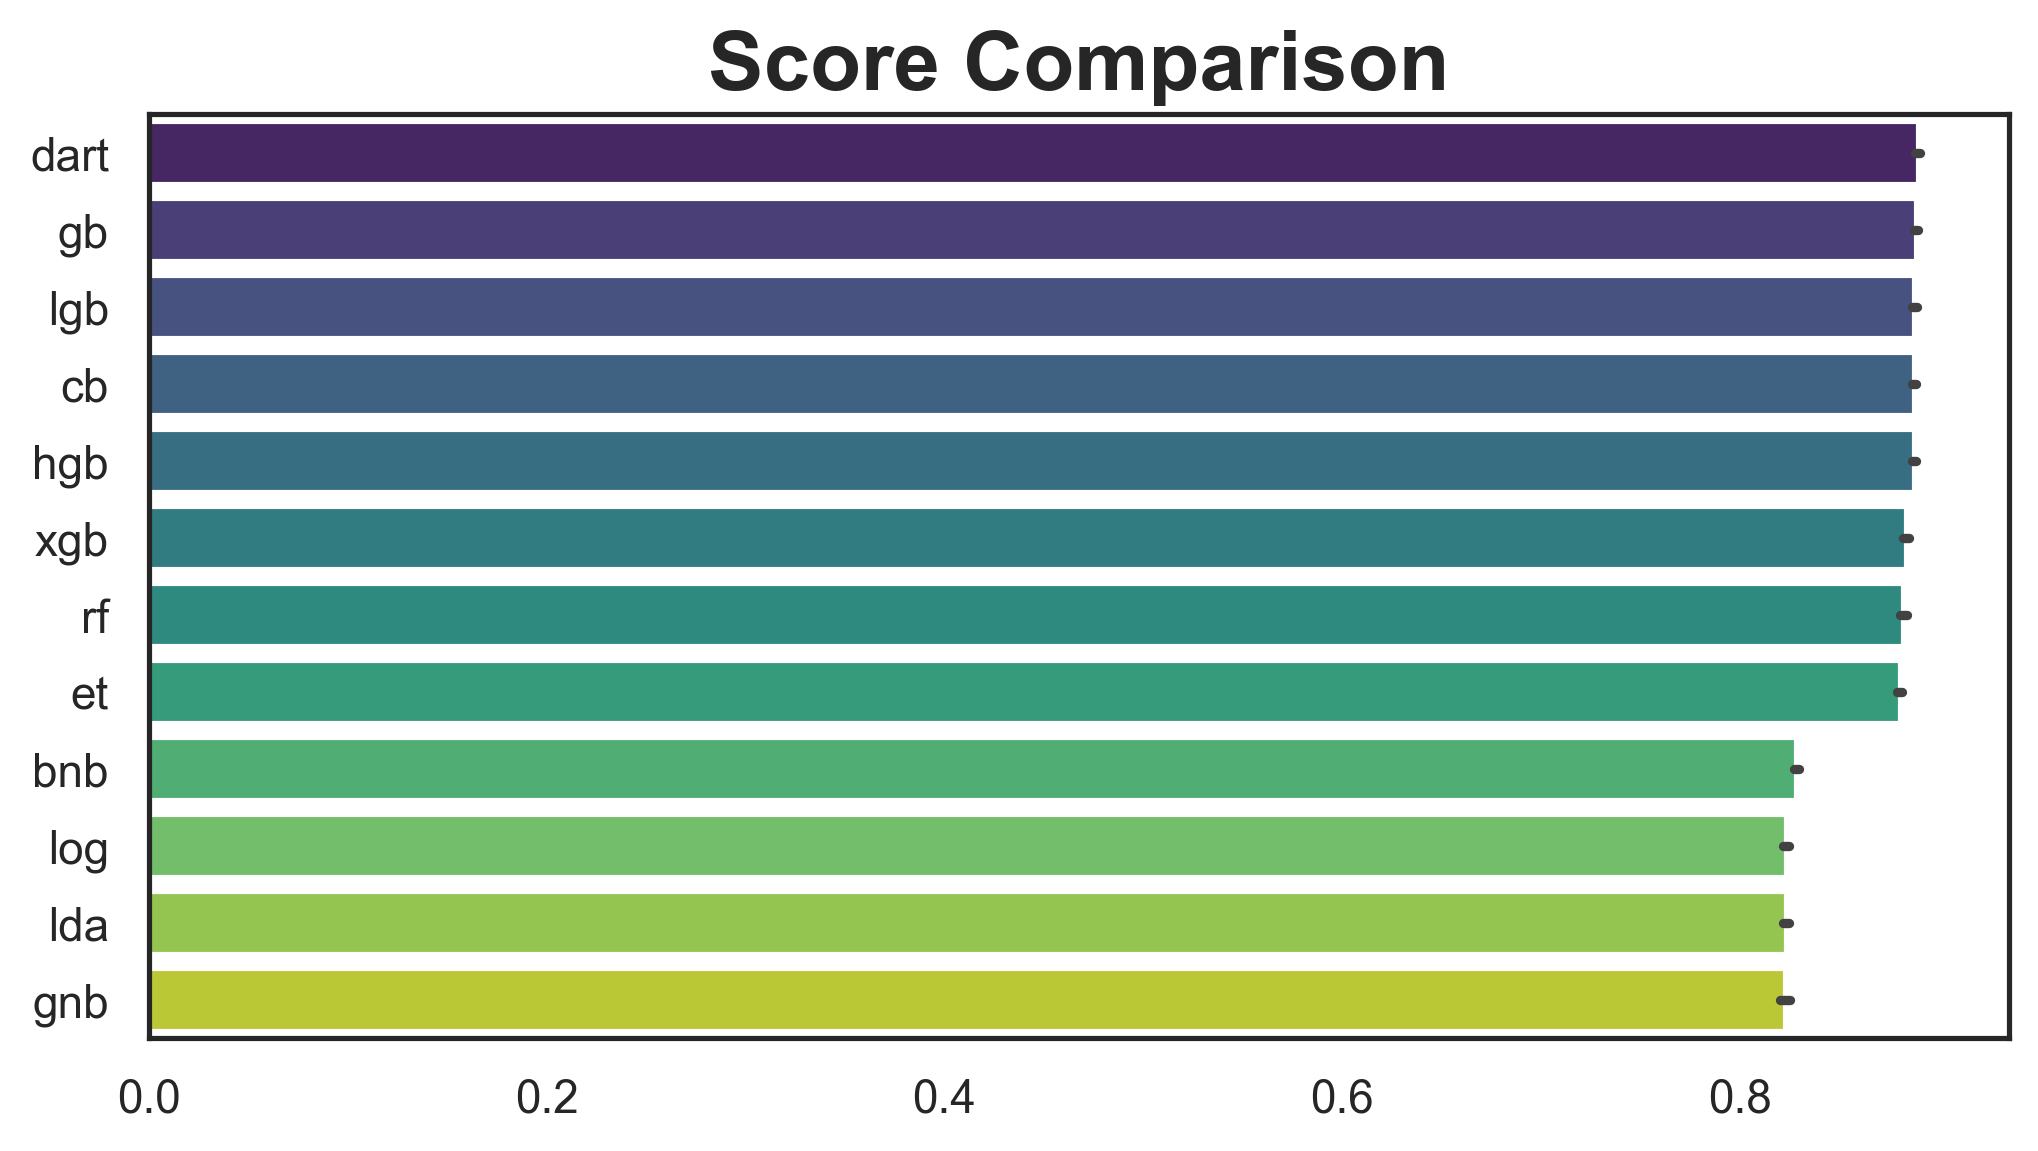

In [25]:
plt.figure(figsize = (8, 4), dpi = 300)
sns.barplot(data = score_list.reindex((-1 * score_list).mean().sort_values().index, axis = 1), palette = 'viridis', orient = 'h')
plt.title('Score Comparison', weight = 'bold', size = 20)
plt.show()


# Voting Ensemble
Now let's try to define the weight of each model and then build a voting ensemble. We will use Ridge Classifier to define the weight by fitting it on OOF prediction and the true label.

In [26]:
weights = RidgeClassifier(random_state = seed).fit(oof_list, df_train.Exited).coef_[0]
pd.DataFrame(weights, index = list(oof_list), columns = ['weight per model'])

,weight per model
log,-0.225107
lda,0.135758
gnb,-0.047529
bnb,0.072534
rf,0.105126
et,0.264112
xgb,0.202675
lgb,-0.026905
dart,0.609365
cb,0.791918


After defining the weight, we can start building a Voting Ensemble of our models.

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 12
[LightGBM] [In

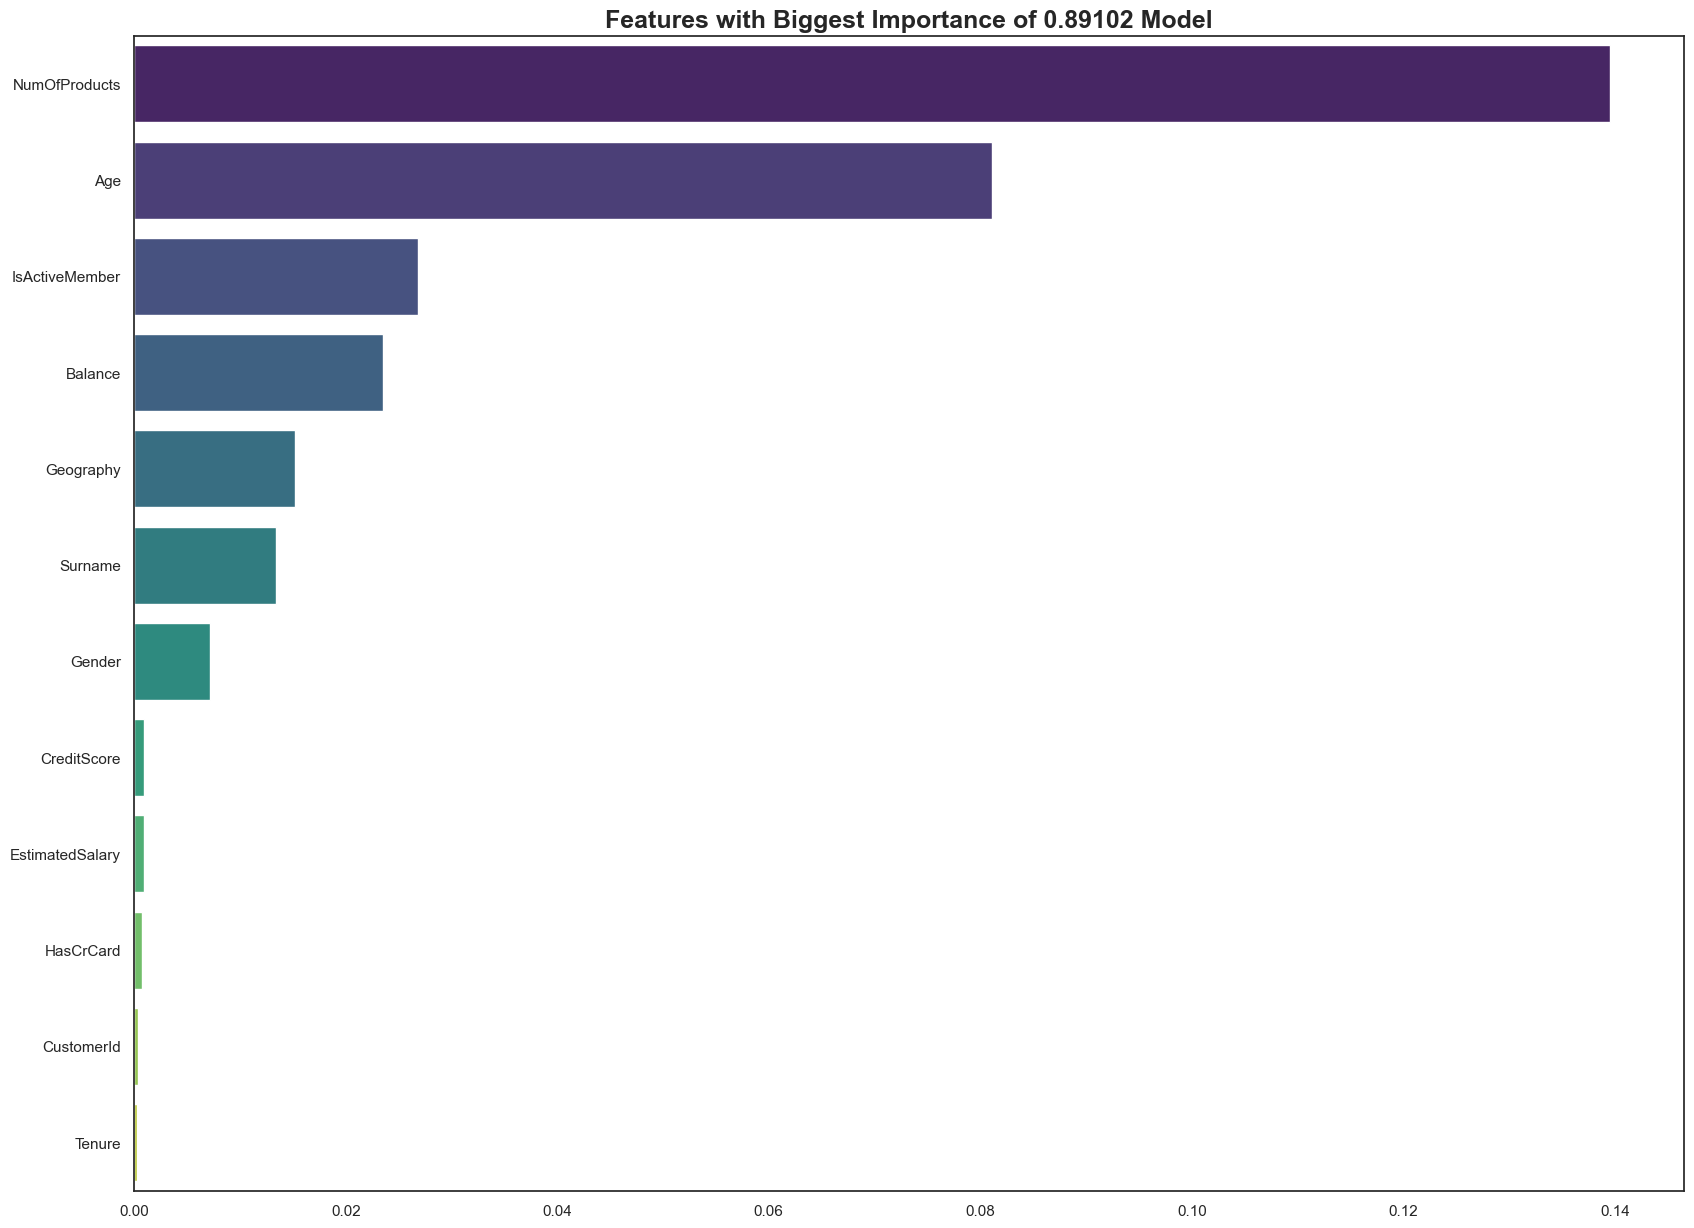

In [27]:
voter = VotingClassifier(models, weights = weights, voting = 'soft')

_ = cross_val_score(dataset=df_train,
                    estimator= make_pipeline(MEstimateEncoder(cols = categorical_features), StandardScaler(), voter),
                    cv = skf,
                    seed=seed,
                    label="",
                    show_importance = True)

We can see an improvement in the CV score above!

# Prediction and Submission
Finally, let's train our chosen model on the whole train dataset and do prediction on the test dataset.

In [28]:
model = make_pipeline(
    MEstimateEncoder(cols = categorical_features),
    StandardScaler(),
    voter
)

model.fit(X, y)

[LightGBM] [Info] Number of positive: 34921, number of negative: 130113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1374
[LightGBM] [Info] Number of data points in the train set: 165034, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211599 -> initscore=-1.315315
[LightGBM] [Info] Start training from score -1.315315
[LightGBM] [Info] Number of positive: 34921, number of negative: 130113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1374
[LightGBM] [Info] Number of data points in the train set: 165034, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211599 -> initscore=-1.31531

Pipeline(steps=[('mestimateencoder',
                 MEstimateEncoder(cols=['Surname', 'Geography', 'Gender'])),
                ('standardscaler', StandardScaler()),
                ('votingclassifier',
                 VotingClassifier(estimators=[('log',
                                               LogisticRegression(max_iter=1000000,
                                                                  random_state=10)),
                                              ('lda',
                                               LinearDiscriminantAnalysis()),
                                              ('gnb', GaussianNB()),
                                              ('bnb', BernoulliNB()),
                                              ('rf',
                                               RandomForestClassifier(ra...
                                                              random_state=10)),
                                              ('cb',
                                               <catboost.core.CatBoostClassifier object at 0x000001F69074E910>),
                                              ('gb',
                                               GradientBoostingClassifier(random_state=10)),
                                              ('hgb',
                                               HistGradientBoostingClassifier(random_state=10))],
                                  voting='soft',
                                  weights=array([-0.22510665,  0.13575813, -0.04752889,  0.07253382,  0.10512593,
        0.26411203,  0.20267544, -0.02690474,  0.60936529,  0.79191801,
        0.19374233, -0.03592432])))])

In [30]:
submission = df_test.copy()
submission['Exited'] = model.predict_proba(submission)[:, 1]

submission.Exited.to_csv('data/submission.csv')

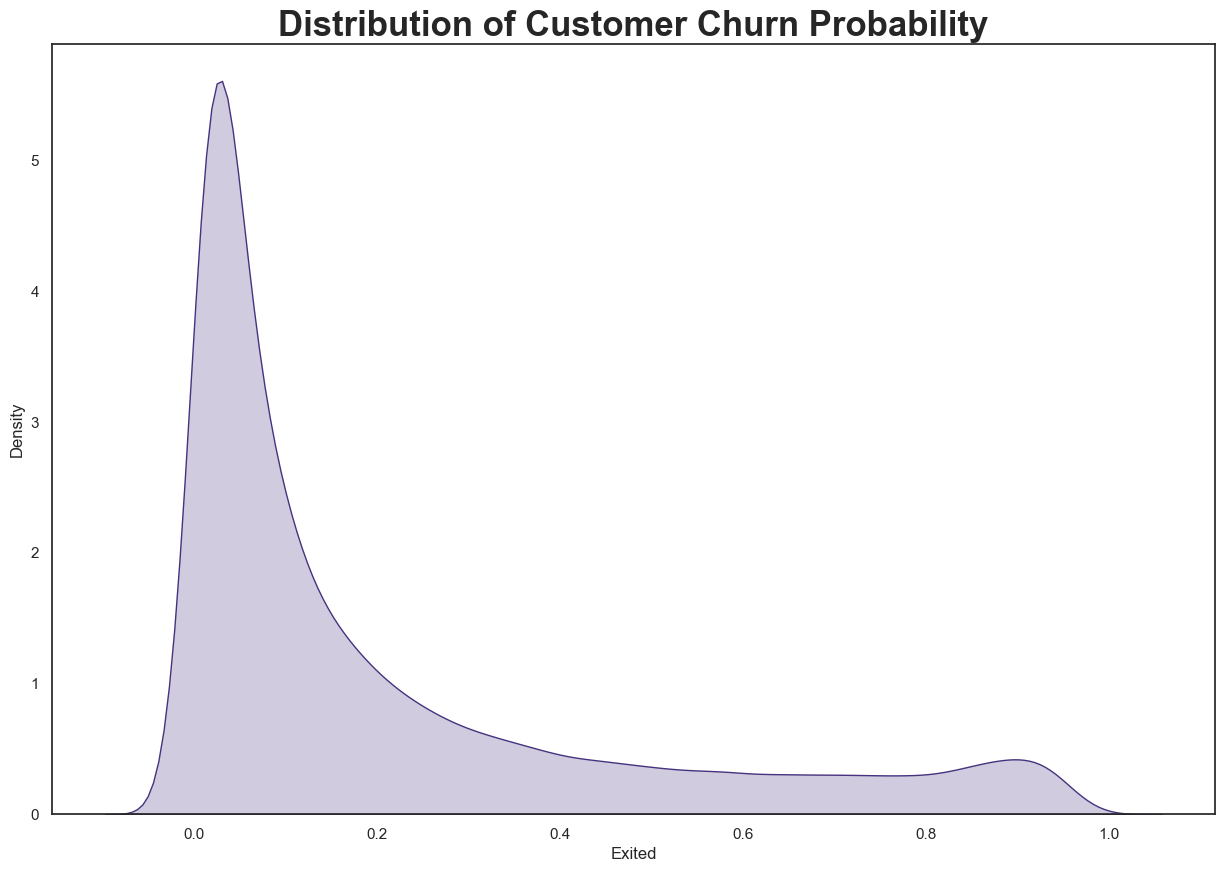

In [31]:
plt.figure(figsize = (15, 10))
sns.kdeplot(submission.Exited, fill = True)
plt.title("Distribution of Customer Churn Probability", weight = 'bold', size = 25)
plt.show()